<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li></li><li><span><a href="#Изучение-файла" data-toc-modified-id="Изучение-файла-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Изучение файла</a></span></li><li><span><a href="#Разбиение-данных-на-выборки" data-toc-modified-id="Разбиение-данных-на-выборки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Разбиение данных на выборки</a></span></li><li><span><a href="#Исследование-модели" data-toc-modified-id="Исследование-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Исследование модели</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Проверка-модели-на-тестовой-выборке" data-toc-modified-id="Проверка-модели-на-тестовой-выборке-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Проверка модели на тестовой выборке</a></span></li><li><span><a href="#(бонус)-Проверка-модели-на-адекватность" data-toc-modified-id="(бонус)-Проверка-модели-на-адекватность-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>(бонус) Проверка модели на адекватность</a></span><ul class="toc-item"><li><span><a href="#Построим-&quot;глупую-модель&quot;,-которая-будет-заполнять-предсказания-одной-константой." data-toc-modified-id="Построим-&quot;глупую-модель&quot;,-которая-будет-заполнять-предсказания-одной-константой.-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Построим "глупую модель", которая будет заполнять предсказания одной константой.</a></span></li><li><span><a href="#Посмотрим-метрики,-которые-более-стабильно-работают-на-несбалансированных-классах-(precision,-recall):" data-toc-modified-id="Посмотрим-метрики,-которые-более-стабильно-работают-на-несбалансированных-классах-(precision,-recall):-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Посмотрим метрики, которые более стабильно работают на несбалансированных классах (precision, recall):</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li><li><span><a href="#Чек-лист-готовности-проекта" data-toc-modified-id="Чек-лист-готовности-проекта-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист готовности проекта</a></span></li></ul></div>

# Рекомендация тарифов

В нашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы. Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — она уже сделана в прошлом проекте.

Построим модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверим *accuracy* на тестовой выборке в конце проекта.

## Изучение файла

In [ ]:
import pandas as pd
pd.set_option('display.float_format', '{:,.2f}'.format) #при выводе describe задаем количество нужных знаков
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc, roc_auc_score, roc_curve

import warnings
warnings.filterwarnings("ignore");

RAND = 42

In [ ]:
df = pd.read_csv('/datasets/users_behavior.csv')
df.head()

In [ ]:
df.info()

Пропусков в данных нет.

Приведем к нужным типам:

In [ ]:
df.is_ultra = df.is_ultra.astype('bool')
df[['calls', 'messages']] = df[['calls', 'messages']].astype('int64')
df.info()

In [ ]:
df.describe(exclude=np.number).T

Пользователей тарифа `smart` почти в 2 раза больше, чем тарифа `ultra`

In [ ]:
df.describe()

Видно, что размах между верхним квартилем и максимумом довольно большой, относительно других межквартильных интервалов, причем, для всех признаков.

Разделим признаки на категориальные и численные:

In [7]:
num_cols = ['calls', 'minutes', 'messages', 'mb_used']
cat_cols = ['is_ultra']

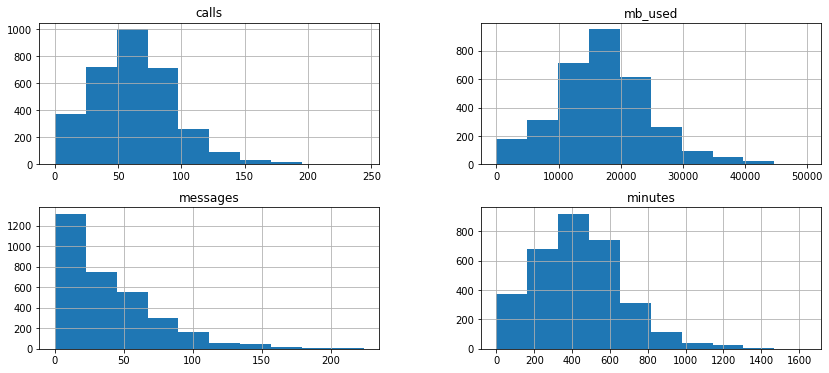

In [8]:
df.hist(num_cols, figsize=(14,6));

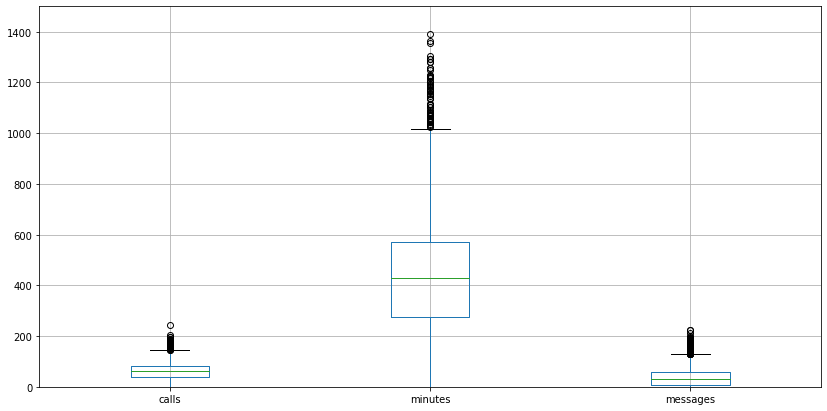

In [9]:
df.boxplot(num_cols[:-1], figsize=(14,7))
plt.ylim(0,1500);

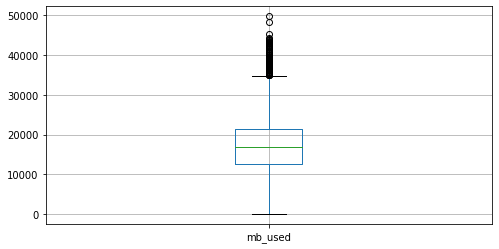

In [10]:
df.boxplot(num_cols[-1], figsize=(8,4));

Распределения имеют положительную скошенность: наблюдаются выбросы в больших значениях.

## Разбиение данных на выборки

In [11]:
features = df.drop('is_ultra', axis=1)
target = df['is_ultra']

In [12]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, shuffle=True, random_state=RAND)

features_train, features_valid, target_train, target_valid = train_test_split(
    features_train, target_train, test_size=0.25, shuffle=True, random_state=RAND)

Проверим как сделано разбиение:

In [13]:
features_train.shape[0], features_valid.shape[0], features_test.shape[0]

(1928, 643, 643)

## Исследование модели

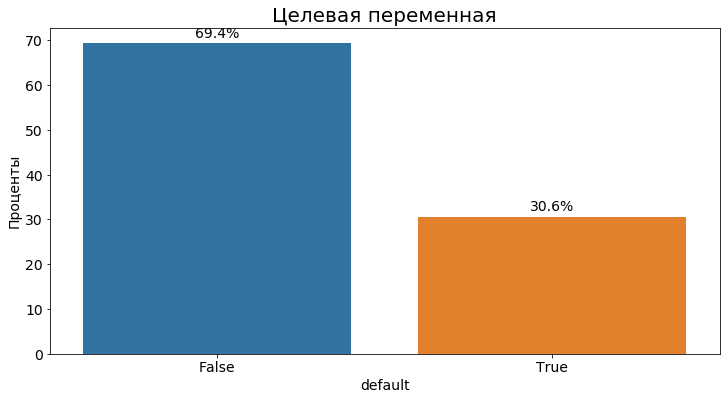

In [14]:
norm_target = (df['is_ultra']
               .value_counts(normalize=True)
               .mul(100)
               .rename('percent')
               .reset_index())

plt.figure(figsize=(12, 6))
ax = sns.barplot(x='index', y='percent', data=norm_target)

# Вывод значений-процентов над графиками - annotate()
# В цикле смотрим каждый столбец графика и на нем отмечаем значения
for p in ax.patches:
    percentage = '{:.1f}%'.format(p.get_height())
    ax.annotate(percentage,  # текст
                (p.get_x() + p.get_width() / 2., p.get_height()), # координата xy=(x,y) (от левой нижней)
                ha='center', # центрирование
                va='center',
                xytext=(0, 10),
                textcoords='offset points', # точка смещения относительно координаты
                fontsize=14)

plt.title('Целевая переменная', fontsize=20)

plt.xlabel('default', fontsize=14)
plt.ylabel('Проценты', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14);

Видно, что классы несбалансированы, метрика `accuracy` будет непоказательной. Но так как требуется в задании пользоваться ей, то подтвердим гипотезу.

**Решающее дерево:**

In [15]:
best_model_DT = None
best_result_DT = 0
for depth in range(1, 10):
    for samples_split in range(2, 6):
        model = DecisionTreeClassifier(random_state=RAND,
                                   max_depth=depth, min_samples_split=samples_split) 
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = accuracy_score(target_valid, predictions) 
        if result > best_result_DT:
            best_model_DT = model
            best_result_DT = result

best_model_DT, best_result_DT

(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=9,
                        max_features=None, max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=4,
                        min_weight_fraction_leaf=0.0, presort=False,
                        random_state=42, splitter='best'),
 0.7900466562986003)

**Случайный лес:**

In [16]:
%%time
best_model_RF = None
best_result_RF = 0
for depth in range(1, 10):
    for est in range(1, 40):
        model = RandomForestClassifier(random_state=RAND,
                                   max_depth=depth, n_estimators=est) 
        model.fit(features_train, target_train) 
        predictions = model.predict(features_valid) 
        result = accuracy_score(target_valid, predictions) 
        if result > best_result_RF:
            best_model_RF = model
            best_result_RF = result

best_model_RF, best_result_RF

CPU times: user 14.2 s, sys: 84.1 ms, total: 14.3 s
Wall time: 14.3 s


(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                        max_depth=8, max_features='auto', max_leaf_nodes=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=13,
                        n_jobs=None, oob_score=False, random_state=42, verbose=0,
                        warm_start=False),
 0.807153965785381)

**Логистическая регрессия:**

In [17]:
model_LR = LogisticRegression(random_state=RAND) 
model_LR.fit(features_train, target_train) 
result = model_LR.score(features_valid, target_valid) 

print("Accuracy модели логистической регрессии на валидационной выборке:", result)

Accuracy модели логистической регрессии на валидационной выборке: 0.7216174183514774


### Вывод

In [18]:
print(f'Лучшая модель: {best_model_RF} с accuracy: {best_result_RF}.')

Лучшая модель: RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=8, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False) с accuracy: 0.807153965785381.


## Проверка модели на тестовой выборке

**DecisionTree:**

In [19]:
pred_test_DT = best_model_DT.predict(features_test)
pred_proba_test_DT = best_model_DT.predict_proba(features_test)

In [20]:
pred_test_DT_score = best_model_DT.score(features_test, target_test)
pred_test_DT_score

0.7916018662519441

**RandomForest:**

In [21]:
pred_test_RF = best_model_RF.predict(features_test)
pred_proba_test_RF = best_model_RF.predict_proba(features_test)
pred_test_RF_score = best_model_RF.score(features_test, target_test)
pred_test_RF_score

0.8195956454121306

**LogisticRegression:**

In [22]:
pred_test_LR = model_LR.predict(features_test)
pred_proba_test_LR = model_LR.predict_proba(features_test)
pred_test_LR_score = accuracy_score(target_test, pred_test_LR)
pred_test_LR_score

0.702954898911353

**Лучший результат:**

In [23]:
max(pred_test_DT_score,
   pred_test_RF_score,
   pred_test_LR_score)

0.8195956454121306

## (бонус) Проверка модели на адекватность

### Построим "глупую модель", которая будет заполнять предсказания одной константой.

Выведем наиболее встречающийся таргет среди тренировочных данных:

In [24]:
target_train.value_counts()

False    1323
True      605
Name: is_ultra, dtype: int64

Это `False`. Сделаем предсказание этой константой:

In [25]:
dummy = DummyClassifier(strategy='constant', random_state=RAND, constant=False).fit(features_train, target_train)
dummy_pred = dummy.predict(features_test)

In [26]:
accuracy_score(target_test, dummy_pred)

0.7076205287713841

Получили довольно большую точность.  
Поэтому в несбалансированных классах метрика `accuracy` часто малоэффективна для проверки модели.

### Посмотрим метрики, которые более стабильно работают на несбалансированных классах (precision, recall):

<img src='http://3.bp.blogspot.com/-cS83mPIWFqU/Wuq1vw0TrpI/AAAAAAAACY8/qEVMoTUmvkIwNbtbrELeGhJoC4yYsrVrQCK4BGAYYCw/s1600/prec.png' width="300">
<img src='http://1.bp.blogspot.com/-_-bHkzJAneg/Wuq1oUu_vTI/AAAAAAAACY0/E2UIsd359x0GV_9IgGv0Iax6Z3kGYM9dQCK4BGAYYCw/s1600/rec.png' width="250">

In [27]:
print('DecisionTree precision: {:10.4f}'.format(precision_score(target_test, pred_test_DT)))
print('RandomForest precision: {:10.4f}'.format(precision_score(target_test, pred_test_RF)))
print('LogRegression precision: {:10.4f}\n'.format(precision_score(target_test, pred_test_LR)))

print('DecisionTree recall: {:10.4f}'.format(recall_score(target_test, pred_test_DT)))
print('RandomForest recall: {:10.4f}'.format(recall_score(target_test, pred_test_RF)))
print('LogRegression recall: {:10.4f}'.format(recall_score(target_test, pred_test_LR)))


DecisionTree precision:     0.7143
RandomForest precision:     0.8000
LogRegression precision:     0.4348

DecisionTree recall:     0.4787
RandomForest recall:     0.5106
LogRegression recall:     0.0532


Видно, что логистическая регрессия дала плохие показатели по каждой из метрик, особенно по полноте.  
Дерево решений, как и случайный лес довольно хорошо показали себя на метрике `precision`, в то время как метрика `recall` дает нерадужный результат(верно предсказали только половину положительных значений).

**ROC-кривая:**

ROC-AUC нужно измерять между истинными значениями и вероятностями класса 1. Аналогично и со всеми методами связанными с roc-auc. `predict_proba` же выдает вероятности для каждого класса по порядку (сначала 0, потом 1 и тд).

Построим кривую для всех моделей:

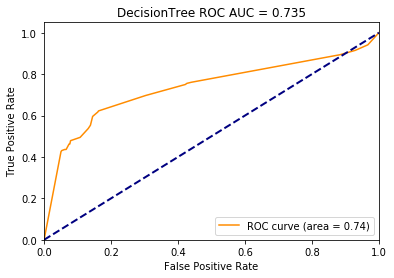

In [28]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test_DT[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('DecisionTree ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

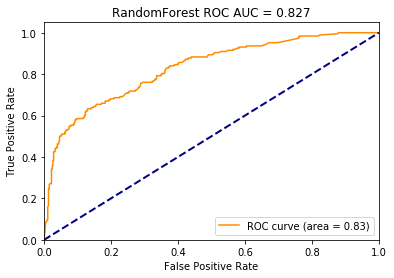

In [29]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test_RF[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('RandomForest ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

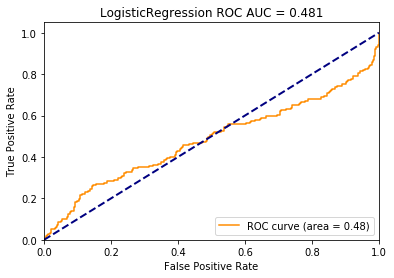

In [30]:
fpr, tpr, thresholds = roc_curve(target_test, pred_proba_test_LR[:,1])

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('LogisticRegression ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

## Вывод

Видно, что логистическая регрессия здесь работает не лучше модели, которая случайно предсказывает класс.  
Случайный лес справился лучше дерева решений, да и в целом из всех предсказанных положительных значений (значений тарифа `ultra`), большой процент пользователей им действительно пользовался.  
Однако касаемо процента предсказанного тарифа ультра из всех пользователей, совпадения пришлись лишь в половине случаев.

## Чек-лист готовности проекта

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гиперпараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
